In [334]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer


# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist


from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]


## Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services
In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.
The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

-----------

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [335]:
# load in the data
azdias_short_df = pd.read_pickle("./azdias_short.pkl")  
azdias_short_df

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
848815,956771,1,1.0,12.0,NaN,NaN,NaN,NaN,12.0,6.0,...,2.0,9.0,12.0,10.0,NaN,9.0,4.0,3,2,3
299816,536767,-1,1.0,0.0,NaN,NaN,NaN,NaN,21.0,1.0,...,1.0,2.0,3.0,3.0,3.0,8.0,3.0,1,2,2
570748,393990,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,8.0,9.0,6.0,6.0,9.0,7.0,1,1,1
354371,596074,-1,9.0,16.0,NaN,NaN,NaN,NaN,15.0,1.0,...,NaN,2.0,3.0,4.0,2.0,9.0,3.0,1,1,3
329018,586471,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296892,860692,-1,9.0,20.0,NaN,NaN,NaN,NaN,20.0,55.0,...,3.0,8.0,11.0,9.0,5.0,9.0,3.0,5,1,2
44626,941164,-1,9.0,14.0,NaN,NaN,NaN,NaN,14.0,10.0,...,4.0,6.0,9.0,10.0,6.0,9.0,2.0,3,1,3
743978,1050783,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
639416,823443,1,1.0,15.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,4.0,7.0,5.0,3.0,9.0,3.0,1,1,4


In [466]:
azdias_short_df.size

32975140

In [336]:
customers_short_df = pd.read_pickle("./customers_short.pkl")  
customers_short_df


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
182218,110819,1,1.0,12.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,3.0,9.0,2.0,2,COSMETIC,SINGLE_BUYER,0,1,3
147893,158648,3,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,1,COSMETIC,MULTI_BUYER,0,1,3
147678,155512,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,1
146951,177101,2,1.0,12.0,NaN,NaN,NaN,NaN,12.0,0.0,...,7.0,NaN,9.0,1.0,1,FOOD,MULTI_BUYER,0,2,4
169457,86805,1,1.0,18.0,NaN,NaN,NaN,NaN,12.0,2.0,...,2.0,2.0,9.0,2.0,1,FOOD,SINGLE_BUYER,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37032,105294,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,1
73579,91106,-1,3.0,17.0,NaN,NaN,NaN,NaN,17.0,2.0,...,8.0,3.0,9.0,2.0,2,FOOD,MULTI_BUYER,0,2,1
117924,77938,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,0,2,1
146260,86388,2,1.0,16.0,NaN,NaN,NaN,NaN,11.0,6.0,...,4.0,2.0,9.0,2.0,4,FOOD,MULTI_BUYER,0,1,4


### Are there any unique columns in the customer group data v the german pop?

In [337]:
customers_short_df.columns.difference(azdias_short_df.columns)

Index(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='object')

In [468]:
cust_missing_data=pd.DataFrame(customers_short_df.isnull().sum())
cust_missing_data.columns=['nan count']
print((100/customers_short_df.size)*(cust_missing_data.sum()))

nan count    19.498535
dtype: float64


yes there are.
we need to be aware of this for our data pipeline.
note: tested oposite reveals that there are no population features missing from the consumer group.

## lets examine azdias:

In [338]:
azdias_short_df.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912200e+04,89122.000000,81632.000000,81632.000000,8048.000000,2842.000000,560.000000,111.000000,62698.000000,79692.000000,...,76916.000000,81394.000000,81394.000000,81394.000000,78261.000000,81632.000000,79692.000000,89122.000000,89122.000000,89122.000000
mean,6.370787e+05,-0.354738,4.410329,10.861954,11.755219,13.348346,14.482143,15.117117,13.674950,8.221653,...,2.422578,5.993955,7.522692,5.939578,3.939970,7.904621,4.062854,3.354581,1.520567,2.778293
std,2.567256e+05,1.198745,3.637606,7.638119,4.092411,3.190818,2.593449,2.243126,5.082128,15.676494,...,1.166701,2.861750,3.258093,2.773866,1.968426,1.926417,1.956678,1.350486,0.499580,1.070030
min,1.916630e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,9.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.159870e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.371365e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.588990e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,16.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [340]:
azdias_short_df.shape

(89122, 366)

In [463]:
missing_data=pd.DataFrame(azdias_short_df.isnull().sum())
missing_data.columns=['nan count']
missing_data

,nan count
LNR,0
AGER_TYP,0
AKT_DAT_KL,7490
ALTER_HH,7490
ALTER_KIND1,81074
...,...
ALTERSKATEGORIE_GROB,0
EINGEZOGENAM_HH_JAHR_FE,7490
GEBURTSJAHR_FE,0
GEBURTSJAHR_binned,0


In [467]:
print((100/azdias_short_df.size)*(missing_data.sum()))

nan count    10.321084
dtype: float64


In [342]:
import matplotlib.pyplot as plt

df_typ=pd.DataFrame(azdias_short_df.dtypes)
df_typ.columns = ['Types']
Type_summary= pd.DataFrame(df_typ['Types'].value_counts())

<AxesSubplot:>

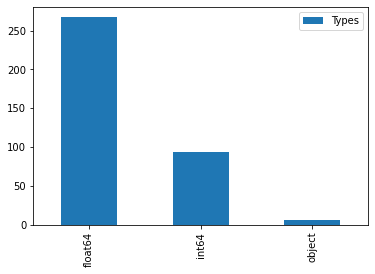

In [343]:
Type_summary.plot.bar()

basic but it will do for now.

In [344]:
object_name_container =[]

for c in azdias_short_df.columns:
    if azdias_short_df[c].dtype == object:
        object_name_container.append(c)

In [345]:
print(object_name_container)
print(len(object_name_container))

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']
6


In [346]:
azdias_short_df.select_dtypes(['object']).head(5)


,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
848815,9B,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W
299816,4C,4.0,24.0,D19_BANKEN_DIREKT,1992-02-10 00:00:00,W
570748,4C,4,24,NaN,1994-08-30 00:00:00,W
354371,3A,3.0,23.0,D19_VERSICHERUNGEN,2005-10-11 00:00:00,W
329018,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
OST_WEST_KZ_encode = pd.get_dummies(azdias_short_df['OST_WEST_KZ'])


In [348]:
OST_WEST_KZ_encode.head()

,O,W
848815,0,1
299816,0,1
570748,0,1
354371,0,1
329018,0,0


In [349]:
EINGEFUEGT_AM_DT=pd.DataFrame(pd.to_datetime(azdias_short_df['EINGEFUEGT_AM'])).reset_index()
EINGEFUEGT_AM_DT.drop(['index'], axis=1,inplace=True)
EINGEFUEGT_AM_DT.head()

,EINGEFUEGT_AM
0,1992-02-12
1,1992-02-10
2,1994-08-30
3,2005-10-11
4,NaT


In [350]:
base_time = pd.Series(['2022-12-10 00:00:00'] * len(azdias_short_df))
base_time =pd.DataFrame(pd.to_datetime(base_time))
base_time.columns = ['base_time']
base_time.head()

,base_time
0,2022-12-10
1,2022-12-10
2,2022-12-10
3,2022-12-10
4,2022-12-10


In [351]:
base_time['EINGEFUEGT_AM_FE']=base_time['base_time']-EINGEFUEGT_AM_DT['EINGEFUEGT_AM']
EINGEFUEGT_AM_FE=pd.DataFrame(base_time['EINGEFUEGT_AM_FE'].dt.days)
EINGEFUEGT_AM_FE.columns= ['EINGEFUEGT_AM_FE']
EINGEFUEGT_AM_FE.head()

,EINGEFUEGT_AM_FE
0,11259.0
1,11261.0
2,10329.0
3,6269.0
4,NaN


In [352]:
print('CAMEO_DEUG_2015:',azdias_short_df['CAMEO_DEUG_2015'].unique())
print('CAMEO_INTL_2015:',azdias_short_df['CAMEO_INTL_2015'].unique())

print('D19_LETZTER_KAUF_BRANCHE:',azdias_short_df['D19_LETZTER_KAUF_BRANCHE'].unique())


CAMEO_DEUG_2015: ['9' 4.0 '4' 3.0 nan 9.0 '2' '8' 2.0 '1' '7' '5' 8.0 7.0 '3' '6' 6.0 5.0
 1.0 'X']
CAMEO_INTL_2015: ['51' 24.0 '24' 23.0 nan 51.0 '13' '55' 13.0 '15' '14' '12' '41' '34' '52'
 54.0 '25' '43' 14.0 22.0 '54' '22' 12.0 '35' 43.0 '44' 44.0 '23' 55.0
 25.0 41.0 '31' 45.0 32.0 '45' 15.0 34.0 33.0 35.0 52.0 '32' 31.0 'XX'
 '33']
D19_LETZTER_KAUF_BRANCHE: ['D19_UNBEKANNT' 'D19_BANKEN_DIREKT' nan 'D19_VERSICHERUNGEN'
 'D19_TELKO_REST' 'D19_SONSTIGE' 'D19_VOLLSORTIMENT' 'D19_BUCH_CD'
 'D19_VERSAND_REST' 'D19_DROGERIEARTIKEL' 'D19_BEKLEIDUNG_REST'
 'D19_SCHUHE' 'D19_BANKEN_LOKAL' 'D19_BEKLEIDUNG_GEH' 'D19_TECHNIK'
 'D19_WEIN_FEINKOST' 'D19_HAUS_DEKO' 'D19_TELKO_MOBILE' 'D19_FREIZEIT'
 'D19_RATGEBER' 'D19_HANDWERK' 'D19_LEBENSMITTEL' 'D19_BANKEN_REST'
 'D19_LOTTO' 'D19_ENERGIE' 'D19_REISEN' 'D19_KINDERARTIKEL'
 'D19_TIERARTIKEL' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG'
 'D19_SAMMELARTIKEL' 'D19_GARTEN' 'D19_KOSMETIK' 'D19_DIGIT_SERV'
 'D19_BIO_OEKO' 'D19_BILDUNG']


In [353]:
azdias_short_df.replace(regex='X', value= '0', inplace=True)


In [354]:
print('CAMEO_DEUG_2015:',azdias_short_df['CAMEO_DEUG_2015'].unique())
print('CAMEO_INTL_2015:',azdias_short_df['CAMEO_INTL_2015'].unique())


CAMEO_DEUG_2015: ['9' 4.0 '4' 3.0 nan 9.0 '2' '8' 2.0 '1' '7' '5' 8.0 7.0 '3' '6' 6.0 5.0
 1.0 '0']
CAMEO_INTL_2015: ['51' 24.0 '24' 23.0 nan 51.0 '13' '55' 13.0 '15' '14' '12' '41' '34' '52'
 54.0 '25' '43' 14.0 22.0 '54' '22' 12.0 '35' 43.0 '44' 44.0 '23' 55.0
 25.0 41.0 '31' 45.0 32.0 '45' 15.0 34.0 33.0 35.0 52.0 '32' 31.0 '00'
 '33']


In [355]:
azdias_short_df["CAMEO_DEUG_2015"] = pd. to_numeric(azdias_short_df["CAMEO_DEUG_2015"])
azdias_short_df["CAMEO_INTL_2015"] = pd. to_numeric(azdias_short_df["CAMEO_INTL_2015"])

print('CAMEO_DEUG_2015:',azdias_short_df['CAMEO_DEUG_2015'].unique())
print('CAMEO_INTL_2015:',azdias_short_df['CAMEO_INTL_2015'].unique())


CAMEO_DEUG_2015: [ 9.  4.  3. nan  2.  8.  1.  7.  5.  6.  0.]
CAMEO_INTL_2015: [51. 24. 23. nan 13. 55. 15. 14. 12. 41. 34. 52. 54. 25. 43. 22. 35. 44.
 31. 45. 32. 33.  0.]


### Options for Object type data:
 As can be seen in previous there are 6 columns containing object type data.
 Examining 2 of these columns the data is text based.
 Certainly we can not use non numberical data in our model we would need to convert this to a numberical format. There are two main options;
 - 1] Convert to a caterogorical value using a class mapper. We have to dismiss this option due to the following reason, this would impose a hierarchical value to the text. We dont know if '1A' has more value/weight than lets say '9C' from CAMEO_DEU_2015. 
 - 2] Use onehot encoding to covert this into a numberical encoding. While this would be the go to option in this type of case, not so in this situation. The reason for this is adding in potentially another 100+ sparce feature columns would add significent noise to the model.

### Reccomendation: drop type= object columns

azdias_short_df = azdias_short_df.select_dtypes(exclude='object')
azdias_short_df.shape
## number of columns should go from 366 to 360.

### Now we understand the fabric of the data types we are looking at lets look at some features where we can compare both data sets.

A number of features in this data set seem obivious factors in how we under stand who the customers are: age related attributes is one such factor

## Feature engineering

count    81632.000000
mean        18.264112
std          7.068872
min          4.000000
25%         12.000000
50%         19.000000
75%         25.000000
max         36.000000
Name: EINGEZOGENAM_HH_JAHR_FE, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='EINGEZOGENAM_HH_JAHR_FE'>

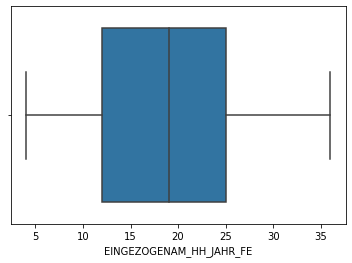

In [356]:
azdias_short_df['EINGEZOGENAM_HH_JAHR_FE']= 2022-azdias_short_df['EINGEZOGENAM_HH_JAHR']
print(azdias_short_df['EINGEZOGENAM_HH_JAHR_FE'].describe())
sns.boxplot(azdias_short_df['EINGEZOGENAM_HH_JAHR_FE'])

<AxesSubplot:xlabel='GEBURTSJAHR', ylabel='EINGEZOGENAM_HH_JAHR_FE'>

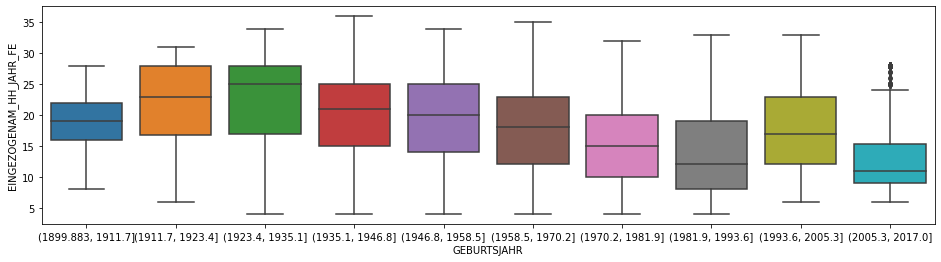

In [359]:
fig = plt.figure(figsize=(16,4))

sns.boxplot(x=pd.cut(azdias_short_df['GEBURTSJAHR'],10), y='EINGEZOGENAM_HH_JAHR_FE', data=azdias_short_df)

In [360]:
labels = [ 20, 30, 40, 50, 60,70,80,90,100,110]

print('GEBURTSJAHR:',azdias_short_df['GEBURTSJAHR'].unique())
### interesting there are some individuals with 0 birthday, cross checked with nans
### lets impute wiht median.
azdias_short_df['GEBURTSJAHR'].replace(0, value= azdias_short_df['GEBURTSJAHR'].median(), inplace=True)
azdias_short_df['GEBURTSJAHR_FE']= 2022-azdias_short_df['GEBURTSJAHR']
azdias_short_df['GEBURTSJAHR_FE_bin']=pd.cut(azdias_short_df['GEBURTSJAHR_FE'],10,labels=labels)
azdias_short_df['GEBURTSJAHR_binned']=pd.DataFrame(azdias_short_df['GEBURTSJAHR_FE_bin'])
print('GEBURTSJAHR_FE_bin:',azdias_short_df['GEBURTSJAHR_FE_bin'].unique())


GEBURTSJAHR: [1943 1996 1967 1942 1949 1950 1964 1959 1988 1921 1978 1970 1936 1976
 1965 1944 1946 1975 1984 1947 1971 1993 1951 1952 1955 2006 1974 1937
 1957 1961 1972 1931 1985 1966 1940 1958 1927 1980 1998 1987 1979 1994
 2012 1983 1981 1963 1932 1960 1939 1933 1990 1973 1969 1941 1989 1968
 1935 2004 1956 2003 1986 1997 1962 2017 1954 1928 1992 1982 1945 1948
 1922 1977 2011 1953 1934 2007 1995 2002 1991 2010 2001 1920 2008 2000
 2014 1938 1930 1923 1916 2009 1925 2013 1929 1918 2015 1926 2016 1919
 1924 1915 1914 2005 1910 1999 1917 1907 1913 1911 1906 1900 1909 1912]
GEBURTSJAHR_FE_bin: [80, 30, 60, 70, 40, 100, 50, 20, 90, 110]
Categories (10, int64): [20 < 30 < 40 < 50 ... 80 < 90 < 100 < 110]


In [361]:
azdias_short_df['MIN_GEBAEUDEJAHR_FE']=2022-azdias_short_df['MIN_GEBAEUDEJAHR']
azdias_short_df['MIN_GEBAEUDEJAHR_FE'].head()

848815    30.0
299816    30.0
570748    28.0
354371    23.0
329018     NaN
Name: MIN_GEBAEUDEJAHR_FE, dtype: float64

In [362]:
percent_missing = azdias_short_df.isnull().sum() * 100 / len(azdias_short_df)
missing_value_df = pd.DataFrame({'column_name': azdias_short_df.columns,
                                 'percent_missing': percent_missing})

In [460]:
missing_value_df.sort_values('percent_missing', inplace=True)
# lets check out how many features have > 20% missing.
# GUidelines would indicate that we drop these columns.
most_missing = missing_value_df[missing_value_df['percent_missing'] > 30] 
print('number of features where we have >30% missing values',most_missing.shape[0])
most_missing

number of features where we have >30% missing values 6


,column_name,percent_missing
KK_KUNDENTYP,KK_KUNDENTYP,65.870380
EXTSEL992,EXTSEL992,73.337672
ALTER_KIND1,ALTER_KIND1,90.969682
ALTER_KIND2,ALTER_KIND2,96.811113
ALTER_KIND3,ALTER_KIND3,99.371648
ALTER_KIND4,ALTER_KIND4,99.875452


<AxesSubplot:>

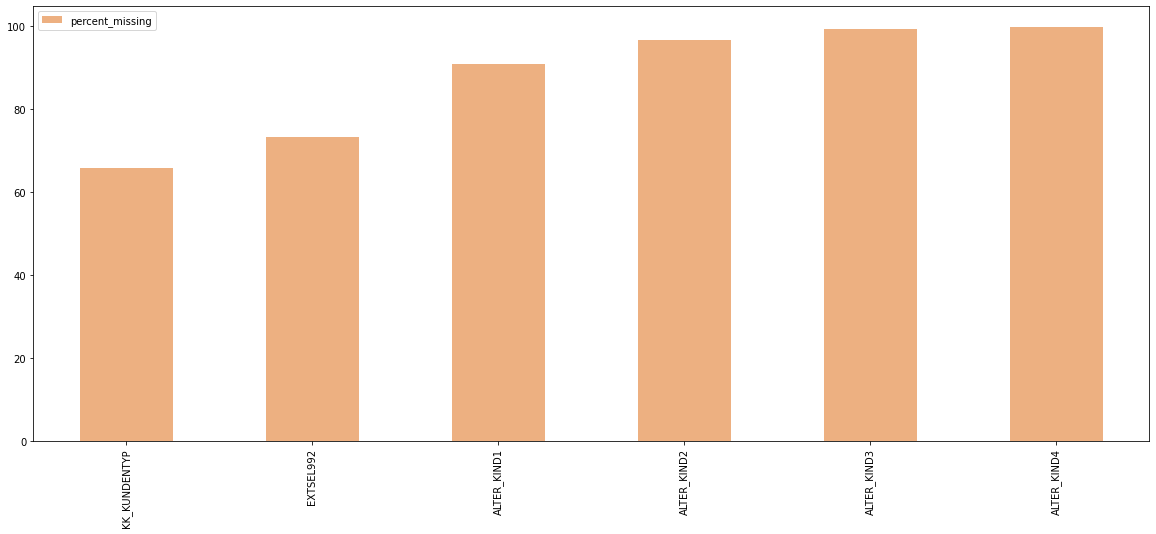

In [364]:
most_missing.plot.bar(figsize=(20,8),colormap='flare')

In [365]:
# lets get the column names for cols we want to drop.


In [366]:
drop_cols=list(most_missing['column_name'].unique())
drop_cols

['KK_KUNDENTYP',
 'EXTSEL992',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4']

In [367]:
azdias_short_df_nan = azdias_short_df.drop(drop_cols, axis=1)
azdias_short_df_nan.shape

(89122, 365)

360 features less 15 which have nans > 20 = 345.
we have 345 features left.

In [368]:
azdias_short_df_nan.dropna(inplace=True)
azdias_short_df_nan.shape

(46714, 365)

<AxesSubplot:>

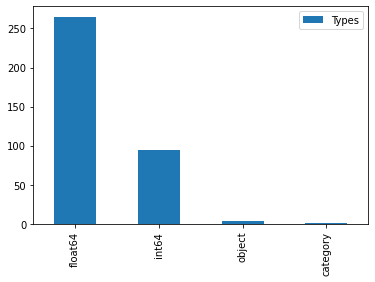

In [369]:
# quick look at types distribution now.
df_typ=pd.DataFrame(azdias_short_df_nan.dtypes)
df_typ.columns = ['Types']
Type_summary= pd.DataFrame(df_typ['Types'].value_counts())
Type_summary.plot.bar()

In [370]:
azdias_short_df = azdias_short_df.select_dtypes(exclude='category')
azdias_short_df.shape

(89122, 370)

lets see if we have any columns which have zero variation that is 0 stdev

In [371]:
azdias_filter_stats = azdias_short_df_nan.describe().T
#azdias_filter_stats
no_change = azdias_filter_stats[azdias_filter_stats['std'] == 0] 
no_change

,count,mean,std,min,25%,50%,75%,max


In this case we have no features with zero variation, ie. we dont need to remove any.

In [372]:
skew_treshold = 0.5
df_skew=pd.DataFrame(customers_short_df.skew(axis = 0, skipna = True))
df_skew=df_skew.reset_index()
df_skew.columns = ['skewed_cols','skew']
df_skew.sort_values('skew', inplace=True)
most_skewed = df_skew[abs(df_skew['skew']) .between(2, 3)]
# abs will allow us to handle +/-ve skews.
# np.log will help with some +ve skew, outlier dection sigma treshold & robust scaler will handle -ve.
skew_cols = list(most_skewed['skewed_cols'].unique())
print(skew_cols)
most_skewed.head



['D19_VERSI_DATUM', 'RT_SCHNAEPPCHEN', 'CJT_TYP_6', 'D19_SOZIALES', 'KBA05_MOD8', 'KBA13_KMH_110', 'PLZ8_BAUMAX', 'D19_VERSAND_REST', 'D19_RATGEBER', 'D19_DROGERIEARTIKEL', 'VERDICHTUNGSRAUM', 'D19_WEIN_FEINKOST', 'KBA05_SEG9', 'D19_FREIZEIT', 'KBA05_ANHANG', 'KBA05_SEG8', 'D19_BANKEN_DIREKT', 'KBA05_ANTG3', 'D19_TELKO_REST', 'KBA05_MOTRAD', 'D19_SCHUHE', 'KBA05_SEG7', 'KBA05_SEG1', 'AKT_DAT_KL', 'D19_LEBENSMITTEL', 'ONLINE_PURCHASE', 'UNGLEICHENN_FLAG', 'D19_BIO_OEKO']


/var/folders/61/_v61r9w145964hxz_vj2hznm0000gn/T/ipykernel_11718/3901201417.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_skew=pd.DataFrame(customers_short_df.skew(axis = 0, skipna = True))


<bound method NDFrame.head of              skewed_cols      skew
85       D19_VERSI_DATUM -2.678756
324      RT_SCHNAEPPCHEN -2.083387
24             CJT_TYP_6 -2.012690
65          D19_SOZIALES  2.000969
158           KBA05_MOD8  2.045060
235        KBA13_KMH_110  2.045250
316          PLZ8_BAUMAX  2.102715
82      D19_VERSAND_REST  2.193417
60          D19_RATGEBER  2.242502
41   D19_DROGERIEARTIKEL  2.291073
347     VERDICHTUNGSRAUM  2.318768
91     D19_WEIN_FEINKOST  2.326868
171           KBA05_SEG9  2.480584
43          D19_FREIZEIT  2.485171
118         KBA05_ANHANG  2.496208
170           KBA05_SEG8  2.524971
28     D19_BANKEN_DIREKT  2.544329
121          KBA05_ANTG3  2.572324
74        D19_TELKO_REST  2.572496
161         KBA05_MOTRAD  2.650607
63            D19_SCHUHE  2.656615
169           KBA05_SEG7  2.667740
162           KBA05_SEG1  2.715754
2             AKT_DAT_KL  2.732887
57      D19_LEBENSMITTEL  2.772507
358      ONLINE_PURCHASE  2.808641
346     UNGLEICHENN_FLAG 

### Comments:
There are two dispatiate types of data in this data set the floats and the ints, these represent numberical data of any value with with huge scale and caterergorical data which will be descrete in nature. This introduces some challanges:
- a] Scale there will be values close to zero, values extreamly far from zero.
- b] outliers looking at the skew and some of the examples graphed above outliers( which can represent errors seem to be factor in this data set which is not surprising)

As with most data sets which are not syntetic ( which seems to be be the case where) we will have to clean up the data set and at a minimum remove outliers.


------------------------------------------------------

## Final cleaning frunction

In [376]:
def transformer(df,std,treshold,imp_level,skew_switch):
    '''
    Description: takes as input a dataframe obj & transforms data for down stream consumption.
    
    10 Main transformation blocks are applied.
    Transformation details are contained in commnents however basic outline is as follows:
    
    1. drop LNR identifer.
    2. one hot east-west location.
    3. depending on which data set we are cleaning population or customer deal automatic with additional columns
    4. Feature engineering or time variables.
    5. deal with X,XX errors in data set replacing with 0.
    6. Feature engineering of GEBURTSJAHR & related into discreate bins.
    7. Find and remove features with > treshold nans, see treshold below.
    8. Drop junk catagory if any.
    9. Decision nan's processing, see imp_level below.
    10. Find & apply non linear transform to skewed columns, Note skew window allows for application on 
        discrete and continous data in "this" data set. Note application for data set comparrisions can lead to 
        misleading results, set skew_switch not = 0. 
    11. Outlier removal @ chosen level.
    
    Input:
    df= Dataframe obj
    std = sigma treshold value for removing outliers from dataset ( column wise) suited for
            data for normal distribution type however can be applied to any distribution.
    treshold= treshold at which a column containing % of nan's will be removed from data set. for best practices follow
                CRISPR-DM guidelines[https://www.ibm.com/docs/it/spss-modeler/saas?topic=dm-crisp-help-overview]
    imp_level = toggle on 'most-frequent' imputer @ value =0 or remove all rows with nan's @ value not= 0
                tip's- for transforming data to preform clustering amalysis set to 0 for ML predict set to not= 0
    skew_switch = toggle on = 0 to enable skew transformation, set not =0 to skip. For comparative analysis set to not=0
                reason for this if a feature in a data set which is less skewed ( more normal aka population data)
                it will be processed in one data set and not the other. Comparing post will reveal large artifical deltas.
    
    Output:
    df = transformed data set.
    
    '''
    
    inital_size=df.size
    df = pd.DataFrame(df.drop(['LNR'], axis=1))

    OST_WEST_KZ_encode = pd.get_dummies(df['OST_WEST_KZ'])
    df.drop(['OST_WEST_KZ'], axis=1,inplace=True)
    OST_WEST_KZ_encode=OST_WEST_KZ_encode
    #
    ## Dealing with additional columns in customer data.
    customer_ex_obj = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
    object_name_container = []
    appended_data =[]
    #
    ## get all the columns of the inputted DF
    for c in df.columns:

        if c in customer_ex_obj:
            data=pd.DataFrame(pd.get_dummies(df[customer_ex_obj]))
            appended_data.append(data)

    if len(appended_data)!=0:
        test=[appended_data[2]]
        appended_data_DF = pd.DataFrame(pd.concat(test))
        appended_data_DF=appended_data_DF
        OST_WEST_KZ_encode=pd.concat([appended_data_DF,OST_WEST_KZ_encode], axis=1)
        df.drop(customer_ex_obj, axis=1,inplace=True)

    #
    ## Replacing engineered features:
    df=pd.concat([df,OST_WEST_KZ_encode], axis=1)
    #
    ##Recode data column to relative days/int
    EINGEFUEGT_AM_DT=pd.DataFrame(pd.to_datetime(df['EINGEFUEGT_AM']))#.reset_index()
    EINGEFUEGT_AM_DT.head()

    base_time = pd.Series(['2022-12-10 00:00:00'] * len(df))
    base_time =pd.DataFrame(pd.to_datetime(base_time))
    base_time.index=df.index
    base_time.columns = ['base_time']

    base_time['EINGEFUEGT_AM_FE']=base_time['base_time']-EINGEFUEGT_AM_DT['EINGEFUEGT_AM']
    EINGEFUEGT_AM_FE=pd.DataFrame(base_time['EINGEFUEGT_AM_FE'].dt.days)
    EINGEFUEGT_AM_FE.columns= ['EINGEFUEGT_AM_FE']
    df.drop(['EINGEFUEGT_AM'], axis=1,inplace=True)

    #
    ## there are a number of XX or X in the dataframe which create string where there should be ints.
    df.replace(regex='X', value= '0', inplace=True)
    df["CAMEO_DEUG_2015"] = pd. to_numeric(df["CAMEO_DEUG_2015"])
    df["CAMEO_INTL_2015"] = pd. to_numeric(df["CAMEO_INTL_2015"])

    #
    ## now that we have processed all our objects lets drop any left behiend
    df = df.select_dtypes(exclude='object')

    #
    ## add comment
    EINGEZOGENAM_HH_JAHR_copy=df.loc[:, ['EINGEZOGENAM_HH_JAHR']]
    df['EINGEZOGENAM_HH_JAHR_FE']= pd.DataFrame(2022-EINGEZOGENAM_HH_JAHR_copy)
    df = df.drop('EINGEZOGENAM_HH_JAHR', axis=1)

    #
    ### lets impute wiht median.
    labels = [ 20, 30, 40, 50, 60,70,80,90,100,110]
    df['GEBURTSJAHR'].replace(0, value= df['GEBURTSJAHR'].median(), inplace=True)
    GEBURTSJAHR_copy= df.loc[:, ['GEBURTSJAHR']]
    df['GEBURTSJAHR_FE']= pd.DataFrame(2022-GEBURTSJAHR_copy)
    ## remove GEBURTSJAHR_FE
    df['GEBURTSJAHR_FE_bin']=pd.cut(df['GEBURTSJAHR_FE'],10,labels=labels)
    df['GEBURTSJAHR_binned']=pd.DataFrame(df['GEBURTSJAHR_FE_bin'])
    ##!! drop some additional cols generated and origional here.
    df = df.drop(['GEBURTSJAHR','GEBURTSJAHR_FE'], axis=1)

    #
    df['MIN_GEBAEUDEJAHR_FE']=pd.DataFrame(2022-df['MIN_GEBAEUDEJAHR'])
    #
    ## cols with high % missing vals
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})

    missing_value_df.sort_values('percent_missing', inplace=True)
    # lets check out how many features have > 20% missing.
    # GUidelines would indicate that we drop these columns.
    most_missing = missing_value_df[missing_value_df['percent_missing'] > treshold]
    drop_cols=list(most_missing['column_name'].unique())
    print("number of columns to drop:", len(drop_cols))
    df = df.drop(drop_cols, axis=1)
    #
    ## remove catagory types junk data
    df = df.select_dtypes(exclude='category')

    #
    num_nan= df.isnull().sum().sum()

    
    if imp_level == 0:
        imput_data = df
        num_nan= df.isnull().sum().sum()

        col_names=df.columns.values

        imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imp_mean.fit(imput_data)
        imput_data=pd.DataFrame(imp_mean.transform(imput_data))
        imput_data.columns = col_names
        imput_data.index = df.index
        df = imput_data
        print("number of nan's imputed with 'most-frequent'", num_nan)
        print(" imputation insertion %", (100/inital_size)*num_nan)
    else:
        num_nan= df.isnull().sum().sum()
        df.dropna(inplace=True)
        print("number of nan's removed", num_nan)
    
    if skew_switch == 0:
        df_skew=pd.DataFrame(df.skew(axis = 0, skipna = True))
        df_skew=df_skew.reset_index()
        df_skew.columns = ['skewed_cols','skew']
        df_skew.sort_values('skew', inplace=True)
        most_skewed = df_skew[(df_skew['skew']).between(0.7, 1.2)]
        # abs will allow us to handle +/-ve skews. and bined data of which is dominant in this data set
        # np.log will help with some +ve skew, outlier dection sigma treshold & robust scaler will handle -ve.
        skew_cols = list(most_skewed['skewed_cols'].unique())
        print("number of Skewed columns", len(skew_cols))
    ## lets convert skw's to more normal dist
        for c in df.columns:

            if c in skew_cols:
                df[c] = np.sqrt(df[c])
                
    else:
        print("not applying skew transform")



    # 4] remove outliers outside sigma level.
    standard_deviations = std
    df=df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < standard_deviations).all(axis=1)]
    
    final_size=df.size
    
    transformation_diff = inital_size-final_size
    print("% of inital dataset remaining:",100-(transformation_diff/(inital_size/100)))
    print(" Transformation complete have a nice day !!! :)")
    return df

---------

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [377]:
azdias_processed = transformer(azdias_short_df,9,30,0,1)
#test = pd.DataFrame(test)
azdias_processed

number of columns to drop: 6
number of nan's imputed with 'most-frequent' 2872171
 imputation insertion % 8.710110101124664
not applying skew transform
% of inital dataset remaining: 93.57032600922999
 Transformation complete have a nice day !!! :)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEZOGENAM_HH_JAHR_FE,GEBURTSJAHR_binned,MIN_GEBAEUDEJAHR_FE,O,W
848815,1.0,1.0,12.0,12.0,6.0,1.0,0.0,0.0,4.0,0.0,...,9.0,4.0,3.0,2.0,3.0,28.0,80.0,30.0,0.0,1.0
299816,-1.0,1.0,0.0,21.0,1.0,0.0,0.0,2.0,1.0,0.0,...,8.0,3.0,1.0,2.0,2.0,12.0,30.0,30.0,0.0,1.0
570748,-1.0,9.0,0.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,...,9.0,7.0,1.0,1.0,1.0,24.0,80.0,28.0,0.0,1.0
354371,-1.0,9.0,16.0,15.0,1.0,0.0,0.0,3.0,1.0,0.0,...,9.0,3.0,1.0,1.0,3.0,17.0,60.0,23.0,0.0,1.0
329018,-1.0,1.0,0.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,...,9.0,3.0,3.0,2.0,3.0,28.0,80.0,30.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296892,-1.0,9.0,20.0,20.0,55.0,0.0,0.0,3.0,51.0,0.0,...,9.0,3.0,5.0,1.0,2.0,20.0,40.0,31.0,0.0,1.0
44626,-1.0,9.0,14.0,14.0,10.0,0.0,0.0,2.0,7.0,0.0,...,9.0,2.0,3.0,1.0,3.0,25.0,80.0,26.0,0.0,1.0
743978,-1.0,1.0,0.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,...,9.0,3.0,3.0,1.0,3.0,28.0,80.0,30.0,0.0,0.0
639416,1.0,1.0,15.0,10.0,1.0,0.0,0.0,3.0,1.0,0.0,...,9.0,3.0,1.0,1.0,4.0,24.0,80.0,29.0,0.0,1.0


### ----------------------------------------------------------

In [378]:
azdias_processed_summary= azdias_processed.describe()
azdias_processed_summary= azdias_processed_summary.T
azdias_processed_summary= pd.DataFrame(azdias_processed_summary['mean'])
azdias_processed_summary.columns = ['Azdias_mean']
azdias_processed_summary

,Azdias_mean
AGER_TYP,-0.356191
AKT_DAT_KL,4.145324
ALTER_HH,9.852310
ALTERSKATEGORIE_FEIN,14.057526
ANZ_HAUSHALTE_AKTIV,7.042640
...,...
EINGEZOGENAM_HH_JAHR_FE,19.114878
GEBURTSJAHR_binned,67.736085
MIN_GEBAEUDEJAHR_FE,28.871141
O,0.188149


In [379]:
customers_short_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
182218,110819,1,1.0,12.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,3.0,9.0,2.0,2,COSMETIC,SINGLE_BUYER,0,1,3
147893,158648,3,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,1,COSMETIC,MULTI_BUYER,0,1,3
147678,155512,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,1
146951,177101,2,1.0,12.0,NaN,NaN,NaN,NaN,12.0,0.0,...,7.0,NaN,9.0,1.0,1,FOOD,MULTI_BUYER,0,2,4
169457,86805,1,1.0,18.0,NaN,NaN,NaN,NaN,12.0,2.0,...,2.0,2.0,9.0,2.0,1,FOOD,SINGLE_BUYER,0,1,4


In [380]:
customers_cleaned = transformer(customers_short_df,9,30,0,1)
customers_cleaned

number of columns to drop: 6
number of nan's imputed with 'most-frequent' 1269651
 imputation insertion % 17.953501789126946
not applying skew transform
% of inital dataset remaining: 95.74714520951628
 Transformation complete have a nice day !!! :)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CUSTOMER_GROUP_MULTI_BUYER,CUSTOMER_GROUP_SINGLE_BUYER,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,O,W,EINGEZOGENAM_HH_JAHR_FE,GEBURTSJAHR_binned,MIN_GEBAEUDEJAHR_FE
182218,1.0,1.0,12.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,28.0,90.0,30.0
147893,3.0,1.0,9.0,9.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,90.0,30.0
147678,-1.0,1.0,0.0,9.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,28.0,90.0,30.0
146951,2.0,1.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,28.0,70.0,30.0
169457,1.0,1.0,18.0,12.0,2.0,0.0,0.0,3.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,23.0,70.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37032,-1.0,1.0,0.0,9.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,28.0,90.0,30.0
73579,-1.0,3.0,17.0,17.0,2.0,0.0,0.0,2.0,2.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,25.0,50.0,27.0
117924,-1.0,1.0,0.0,9.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,28.0,90.0,30.0
146260,2.0,1.0,16.0,11.0,6.0,0.0,0.0,3.0,5.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,28.0,80.0,30.0


In [382]:
customers_cleaned_summary= customers_cleaned.describe()
customers_cleaned_summary= customers_cleaned_summary.T

customers_cleaned_summary

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,18602.0,0.330448,1.389395,-1.0,-1.0,0.0,2.0,3.0
AKT_DAT_KL,18602.0,1.557144,1.719102,1.0,1.0,1.0,1.0,9.0
ALTER_HH,18602.0,8.471347,7.276920,0.0,0.0,9.0,15.0,21.0
ALTERSKATEGORIE_FEIN,18602.0,9.963552,3.553921,0.0,9.0,9.0,12.0,25.0
ANZ_HAUSHALTE_AKTIV,18602.0,3.344855,7.204072,0.0,1.0,1.0,2.0,111.0
...,...,...,...,...,...,...,...,...
O,18602.0,0.057252,0.232330,0.0,0.0,0.0,0.0,1.0
W,18602.0,0.677400,0.467484,0.0,0.0,1.0,1.0,1.0
EINGEZOGENAM_HH_JAHR_FE,18602.0,24.124288,5.762249,4.0,21.0,28.0,28.0,35.0
GEBURTSJAHR_binned,18602.0,81.031072,12.756742,20.0,70.0,90.0,90.0,110.0


In [383]:
customers_cleaned_summary= pd.DataFrame(customers_cleaned_summary['mean'])
customers_cleaned_summary.columns = ['Customers_Mean']

customers_cleaned_summary

,Customers_Mean
AGER_TYP,0.330448
AKT_DAT_KL,1.557144
ALTER_HH,8.471347
ALTERSKATEGORIE_FEIN,9.963552
ANZ_HAUSHALTE_AKTIV,3.344855
...,...
O,0.057252
W,0.677400
EINGEZOGENAM_HH_JAHR_FE,24.124288
GEBURTSJAHR_binned,81.031072


In [384]:
Joined =pd.concat([azdias_processed_summary, customers_cleaned_summary], axis=1, join="inner")
Joined['Delta']= np.abs(Joined['Azdias_mean']-Joined['Customers_Mean'])
#Joined.drop(index = ('LNR'),inplace=True)
Joined.sort_values('Delta', inplace=True)
Joined

,Azdias_mean,Customers_Mean,Delta
D19_VERSI_ONLINE_QUOTE_12,0.000000,0.000000,0.000000
SOHO_KZ,0.000000,0.000000,0.000000
D19_TELKO_ONLINE_QUOTE_12,0.000000,0.000000,0.000000
D19_TELKO_ANZ_12,0.035319,0.036179,0.000860
D19_VERSI_ONLINE_DATUM,9.994860,9.995753,0.000893
...,...,...,...
VK_DISTANZ,7.806270,3.662026,4.144244
EINGEZOGENAM_HH_JAHR_FE,19.114878,24.124288,5.009410
CAMEO_INTL_2015,37.311497,25.051285,12.260212
GEBURTSJAHR_binned,67.736085,81.031072,13.294986


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
/opt/anaconda3/lib/python3.9/site-packages/

<AxesSubplot:xlabel='Azdias_mean', ylabel='Customers_Mean'>

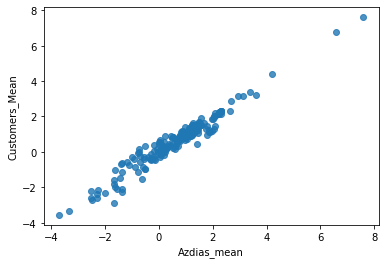

In [385]:
sns.regplot(np.log(Joined['Azdias_mean']),np.log(Joined['Customers_Mean']),ci=95)

In [387]:
high_deltas = Joined[Joined['Delta'] > 2]


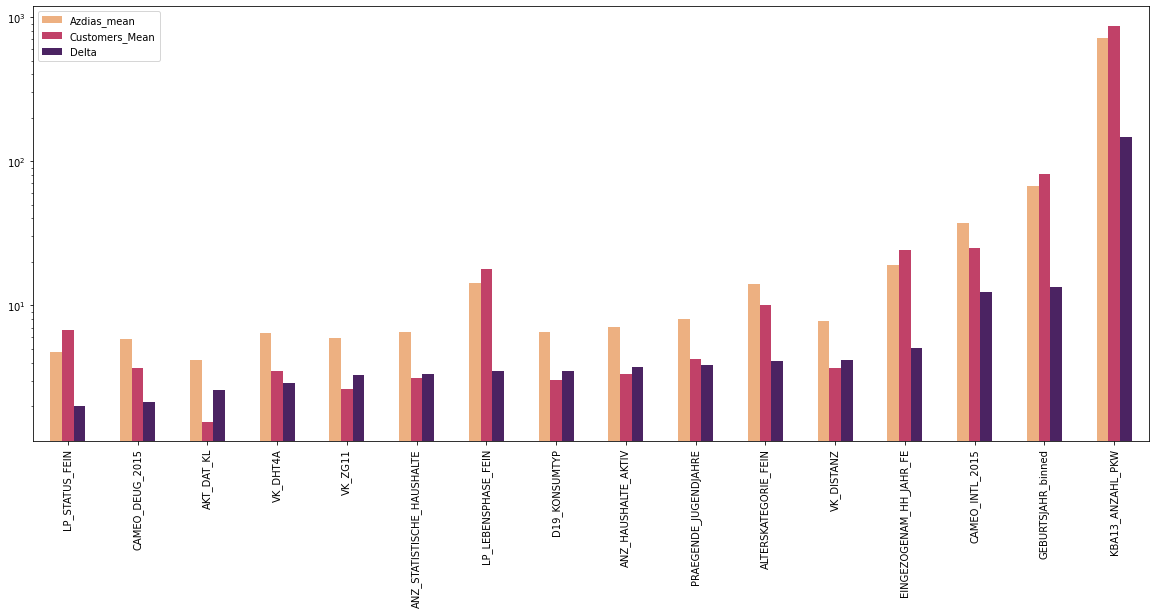

In [388]:

high_deltas.plot.bar(figsize=(20,8),colormap='flare')
plt.yscale('log')


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


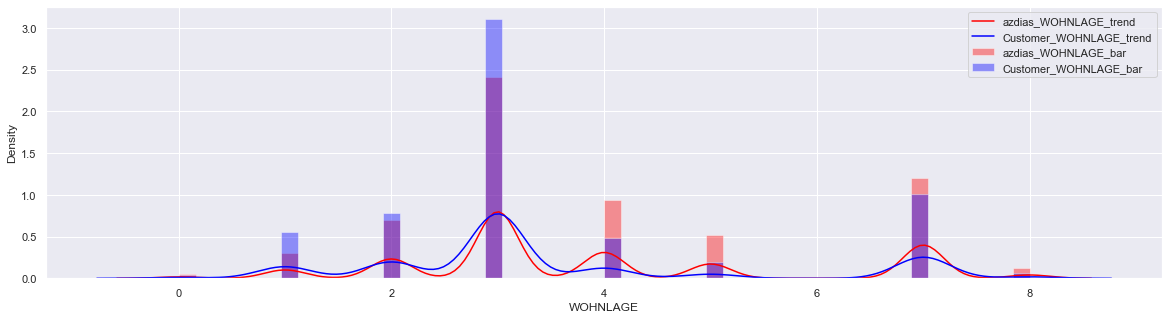

In [485]:

fig, ax = plt.subplots(figsize=(20, 5))

sns.distplot(azdias_processed['WOHNLAGE'],color='red',ax=ax)
sns.distplot(customers_cleaned['WOHNLAGE'],color='blue',ax=ax)
plt.legend(labels=['azdias_WOHNLAGE_trend', 'Customer_WOHNLAGE_trend', 'azdias_WOHNLAGE_bar','Customer_WOHNLAGE_bar'])

plt.show()

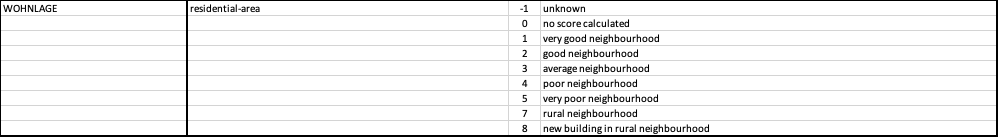

Larger proportion of customers are in 1,2,3 ie. over all good neighbourhoods.
Much lesser representation in poor areas with some representation in rural areas.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


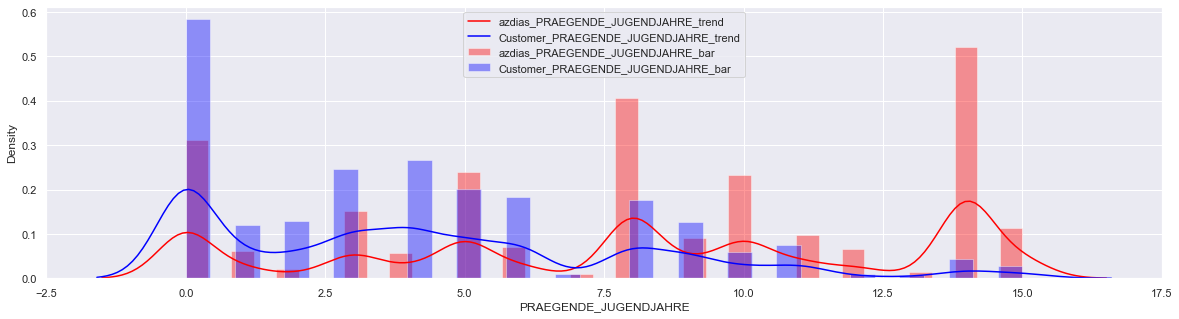

In [486]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.distplot(azdias_processed['PRAEGENDE_JUGENDJAHRE'],color='red')
sns.distplot(customers_cleaned['PRAEGENDE_JUGENDJAHRE'],color='blue')
plt.legend(labels=['azdias_PRAEGENDE_JUGENDJAHRE_trend', 'Customer_PRAEGENDE_JUGENDJAHRE_trend', 'azdias_PRAEGENDE_JUGENDJAHRE_bar','Customer_PRAEGENDE_JUGENDJAHRE_bar'])

plt.show()

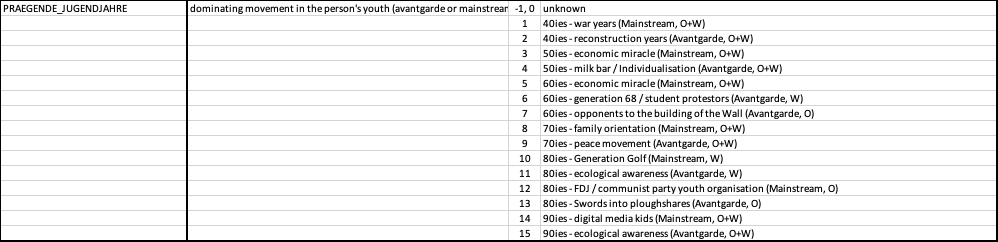

Customers are mainly in groups 1-6, where 3&4 have higer representation than population. These are 50's generation.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


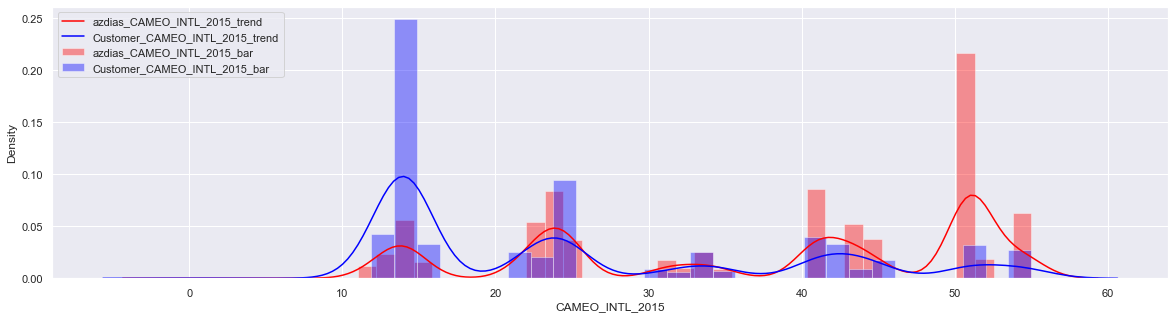

In [487]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.distplot(azdias_processed['CAMEO_INTL_2015'],color='red')
sns.distplot(customers_cleaned['CAMEO_INTL_2015'],color='blue')
plt.legend(labels=['azdias_CAMEO_INTL_2015_trend', 'Customer_CAMEO_INTL_2015_trend', 'azdias_CAMEO_INTL_2015_bar','Customer_CAMEO_INTL_2015_bar'])

plt.show()

We have no data to understand this feature.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


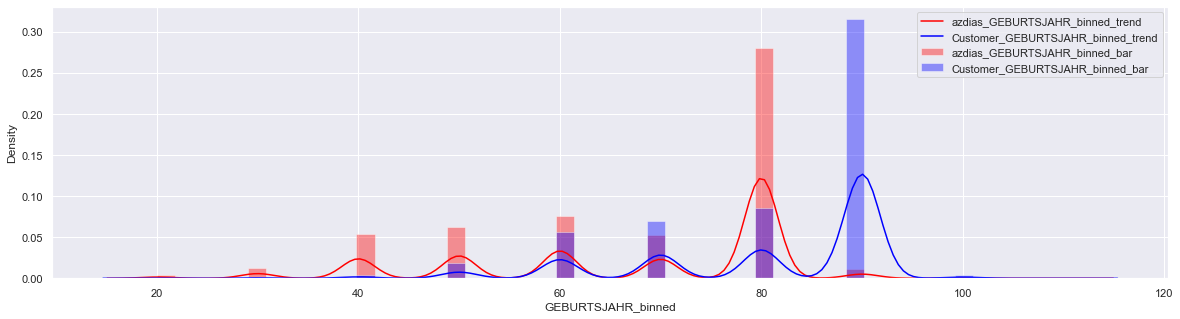

In [488]:
fig, ax = plt.subplots(figsize=(20, 5))


sns.distplot(azdias_processed['GEBURTSJAHR_binned'],color='red')
sns.distplot(customers_cleaned['GEBURTSJAHR_binned'],color='blue')
plt.legend(labels=['azdias_GEBURTSJAHR_binned_trend', 'Customer_GEBURTSJAHR_binned_trend', 'azdias_GEBURTSJAHR_binned_bar','Customer_GEBURTSJAHR_binned_bar'])

plt.show()

This is self explainatory the customer group are older.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try violinplot
  warnings.warn(msg, UserWarning)


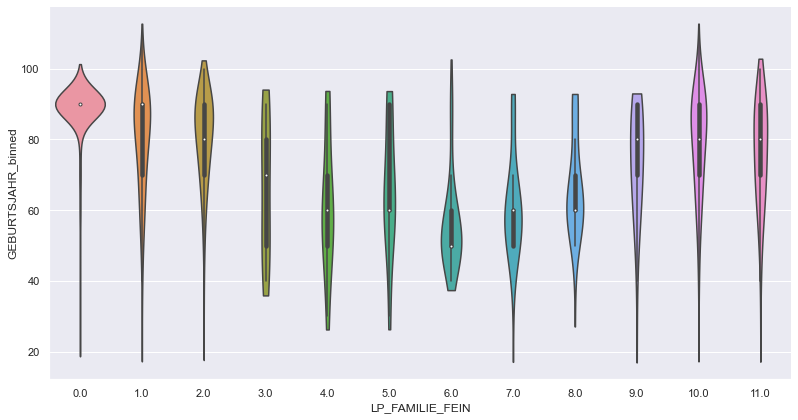

In [491]:

sns.catplot(ax=ax,
    data=customers_cleaned, x="LP_FAMILIE_FEIN", y="GEBURTSJAHR_binned",
    kind="violin", bw=.7, cut=0.3, split=True,
height=6, aspect=15/8)


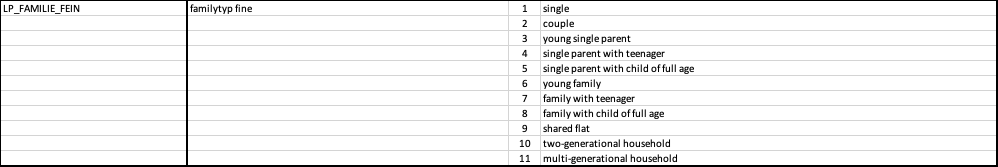

Customer relation ship between life stage fine and family type fine
General population relation ship between life stage gross and family type fine


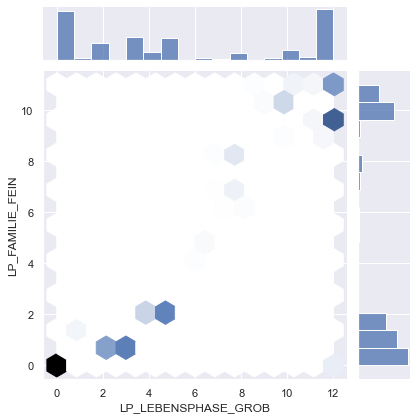

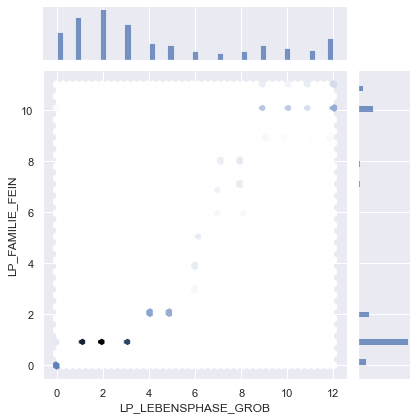

In [493]:


print("Customer relation ship between life stage fine and family type fine")
sns.jointplot(x=customers_cleaned['LP_LEBENSPHASE_GROB'], y=customers_cleaned['LP_FAMILIE_FEIN'], kind="hex")
print("General population relation ship between life stage gross and family type fine")
sns.jointplot(x=azdias_processed['LP_LEBENSPHASE_GROB'], y=azdias_processed['LP_FAMILIE_FEIN'], kind="hex")



#### Here we can see two distinct clusters of customers:
1. 12/10 high income- higher age-multi person house holds
2. 3-5/ High income,3/4 single parent.



LP_FAMILIE_FEIN
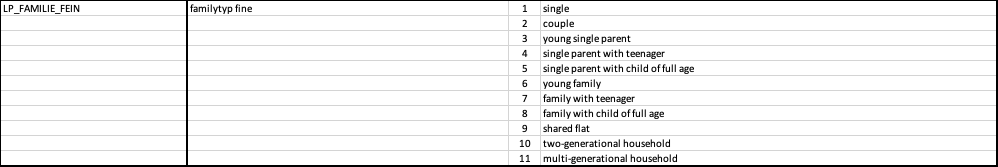
LP_LEBENSPHASE_FEIN
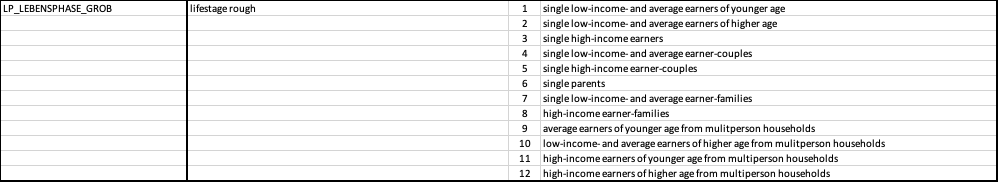

In [ ]:
OST_WEST_KZ
sns.distplot(azdias_processed['OST_WEST_KZ'],color='red')
sns.distplot(customers_cleaned['OST_WEST_KZ'],color='blue')

plt.show()

### Part 1a: unsupervised Learning


In [393]:
from scipy.spatial.distance import cdist


from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

In [394]:
## Removing KBA13_ANZAHL_PKW-> number of cars in the PLZ8 for comparative analysis.

customers_cleaned.drop('KBA13_ANZAHL_PKW', axis=1,inplace=True)
azdias_processed.drop('KBA13_ANZAHL_PKW', axis=1,inplace=True)

In [395]:
robust_Scaler = preprocessing.RobustScaler()
### Robust scaler helps with scaling skew,outliers...
data = robust_Scaler.fit_transform(customers_cleaned)

In [396]:
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [397]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30)
 
for k in K:
    # Building and fitting the model
    kmeanModel = cluster.KMeans(n_clusters=k,  n_init=10, max_iter=300).fit(data)
    kmeanModel.fit(data)
 
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / data.shape[0]) # distorsion from book xxx, distance from center to data point.
    
    inertias.append(kmeanModel.inertia_) #Also called SSE but lets stick with the correct SKlean terminology
 
    mapping1[k] = sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data.shape[0]
    mapping2[k] = kmeanModel.inertia_

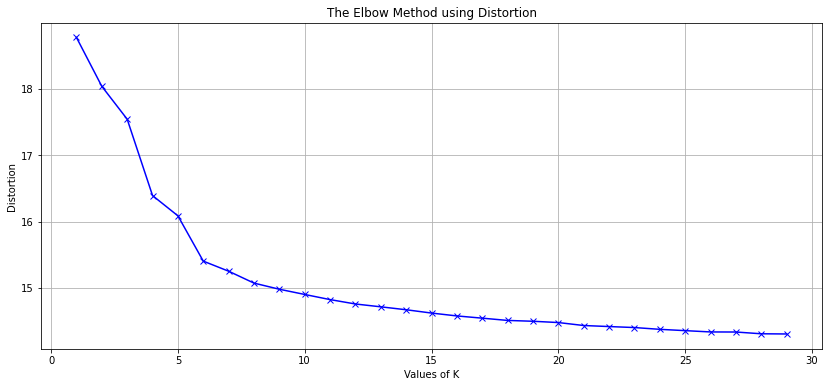

In [398]:
plt.figure(figsize=(14, 6))

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid()
plt.show()

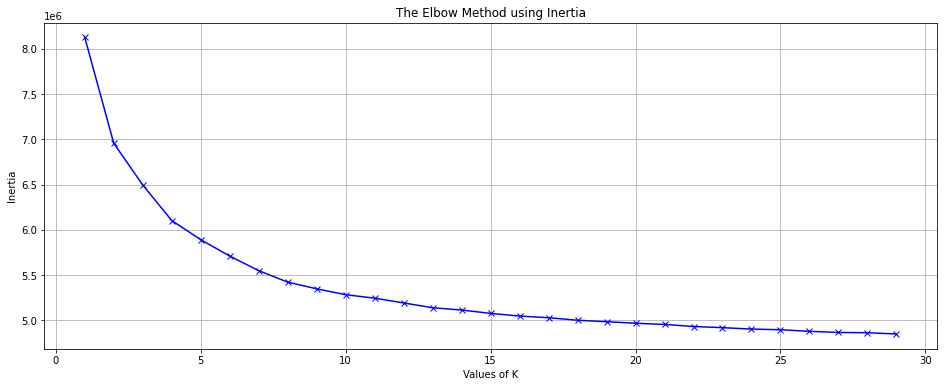

In [55]:
plt.figure(figsize=(16, 6))

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid()

plt.show()

In [56]:
k = 12
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

In [57]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

In [58]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


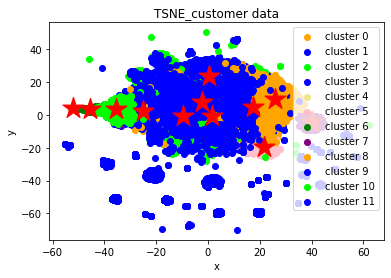

In [59]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE_customer data')

interesting shape.

now lets do the same for the general population of Germany

transformation complete


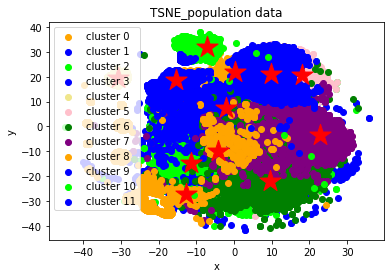

In [60]:
robust_Scaler = preprocessing.RobustScaler()
data_az = robust_Scaler.fit_transform(azdias_processed)

k = 12
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data_az)

data_and_centers = np.r_[data_az,clustered_data_sklearn.cluster_centers_]

XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE_population data')

#### Interesting but there is a lot of noise lets apply dimensionaltiy reduction to our data and examine the clusers further.

In [91]:
pca = PCA().fit(customers_cleaned)


363


Text(0.5, 1.0, 'Cumulative explained variance ratio plot')

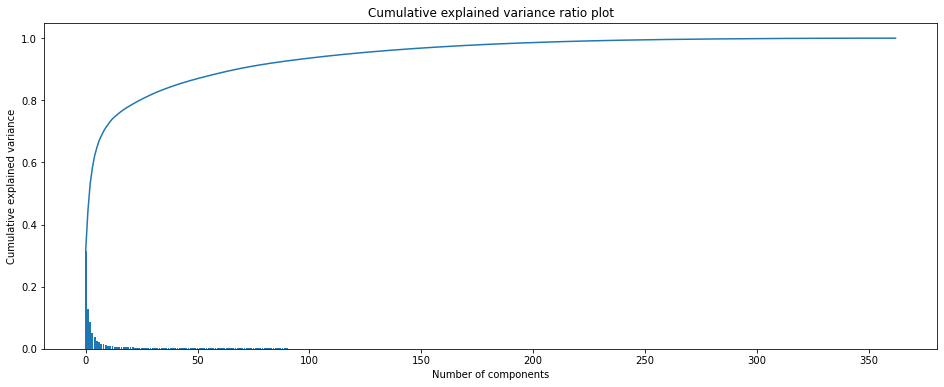

In [92]:

    
num_components = len(pca.explained_variance_ratio_)
print(num_components)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

fig = plt.figure(figsize=(16,6))
ax = plt.subplot()
ax.bar(ind, vals)
ax.plot(ind, cumvals)

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance ratio plot')
    

In [93]:
cum_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'])
cum_variance.set_index(cum_variance.index+1, inplace=True)

var_99 = cum_variance[cum_variance['cumulative_variance']>.95].index[0]
print('{} components explain 95% of variance in the dataset.'.format(var_99))

120 components explain 95% of variance in the dataset.


In [94]:
pca_cust = PCA(n_components=var_99).fit(customers_cleaned)
customers_reduced = pd.DataFrame(pca_cust.transform(customers_cleaned))


In [95]:
top_three_pca = pca.explained_variance_ratio_[:3]


In [96]:
def map_component_to_features(pca, component, column_names):
    """
    Returns weights of features for a selected component.
    
    Input:
    pca - fitted PCA object
    component - PCA component of interest
    column_names - list of original feature names
    
    Output:
    df_features - sorted DataFrame with feature weigths
    """
    
    weights_array = pca.components_[component]
    df_features = pd.DataFrame(weights_array, index = column_names, columns=['weight'])
    return df_features.sort_values(by='weight', ascending=False).round(2)

In [112]:
print("Component 1 explains {:.1%} of variance and is determined by: ".format(top_three_pca[0]))
map_component_to_features(pca_cust, 0, customers_cleaned.columns).head()

Component 1 explains 31.6% of variance and is determined by: 


,weight
LP_LEBENSPHASE_FEIN,0.68
ALTER_HH,0.27
LP_LEBENSPHASE_GROB,0.21
LP_FAMILIE_FEIN,0.19
D19_VERSAND_ONLINE_QUOTE_12,0.10


 ### from this we have:
 1. LP_LEBENSPHASE_FEIN-lifestage fine
 2. ALTER_HH -main age within the household
 3. LP_LEBENSPHASE_GROB - lifestage gross
 4. LP_FAMILIE_FEIN -family type fine
 5. D19_VERSAND_ONLINE_QUOTE_12 - amount of online transactions within all transactions in the segment mail-order 

In [113]:
print("Component 2 explains {:.1%} of variance and is determined by: ".format(top_three_pca[1]))
map_component_to_features(pca_cust, 1, customers_cleaned.columns).head()

Component 2 explains 12.7% of variance and is determined by: 


,weight
ANZ_HAUSHALTE_AKTIV,0.22
ANZ_STATISTISCHE_HAUSHALTE,0.20
ALTERSKATEGORIE_FEIN,0.16
ALTER_HH,0.13
VERDICHTUNGSRAUM,0.07


1. ANZ_HAUSHALTE_AKTIV - number of households known in this building
2. ANZ_STATISTISCHE_HAUSHALTE - We dont have the translation for this- perhaps its some 'secret sauce' feature.
3. ALTERSKATEGORIE_FEIN -  We dont have the exact translation however it is likely to be the Fine version of *age classification through prename analysis*
4. ALTER_HH - main age within the household
5. VERDICHTUNGSRAUM -  We dont have the translation for this- perhaps its some 'secret sauce' feature.

### Transform Azdias population into clusters post PCA and scaling


In [98]:
azdias_processed.shape
print(num_components)

363


In [103]:
pca_azd = PCA(n_components=var_99).fit(azdias_processed)
azdias_reduced = pd.DataFrame(pca_azd.transform(azdias_processed))

col_names_az=azdias_processed.columns.values

robust_Scaler = preprocessing.RobustScaler()


data_red_az = robust_Scaler.fit_transform(azdias_reduced)
data_red_az= pd.DataFrame(data_red_az)
#data_red_az.columns = col_names_az
#data_red_az

k = 10
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data_red_az)

data_red_az['az_cluster'] = pd.Series(clustered_data_sklearn.labels_, index=data_red_az.index)
print(data_red_az.shape)
data_red_az.head()


(86187, 121)


,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,az_cluster
0,0.769751,0.017300,-0.325576,0.160291,0.912431,-0.040047,-0.502051,18.344238,-0.556358,-1.205464,...,-1.111200,-0.607415,-0.823081,-0.352452,-0.131882,-0.285296,0.759583,0.940648,-0.042742,4
1,-1.291224,0.977175,-0.332464,0.177005,2.265942,0.109275,-0.370327,0.059708,2.561568,0.419601,...,1.487749,1.996555,0.954823,-0.661254,0.261208,0.014179,2.394372,-0.696971,-0.689877,9
2,0.107008,-0.580530,-0.302272,1.340490,-0.409655,0.335376,0.247707,0.324763,0.466364,-1.437017,...,-0.839848,-0.231434,-0.687114,-0.908943,0.050181,0.198674,0.305850,-0.542799,0.854970,7
3,-1.029129,-0.096072,0.775827,-0.476033,1.229026,-0.149295,0.429405,-0.707978,0.327593,-0.089382,...,0.114523,-0.196111,0.713507,-0.250582,-0.184530,-0.466889,0.134185,0.017546,0.625931,9
4,0.736700,-0.360788,-1.064117,-0.147920,-0.413304,-0.000107,-0.880427,0.000000,0.554255,0.027157,...,0.176875,0.185203,0.085535,-0.293300,-0.035886,0.047073,0.001190,-0.004486,0.071745,7


In [118]:
robust_Scaler = preprocessing.RobustScaler()
col_names_cu=customers_cleaned.columns.values

data_red_cust = robust_Scaler.fit_transform(customers_reduced)
data_red_cust= pd.DataFrame(data_red_cust)
#data_red_cust.columns= col_names_cu

k = 10
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data_red_cust)

data_red_cust['customer_cluster'] = pd.Series(clustered_data_sklearn.labels_, index=data_red_cust.index)

print(data_red_cust.shape)
data_red_cust.head()

(18602, 121)


,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,customer_cluster
0,0.551666,-1.506241,0.669621,-0.995303,-0.060253,0.009581,-0.579928,0.136474,-0.276063,0.339307,...,0.217002,-1.860748,0.186148,-0.178601,-0.343046,-0.233608,-1.003955,-1.129383,-1.364154,6
1,0.084919,-0.636462,0.131508,-0.256744,-1.823395,0.457851,-0.223680,0.540101,1.223455,0.205619,...,-0.704543,-0.286855,1.194251,-1.990443,0.602807,-1.604901,2.358700,-0.809437,0.575772,6
2,-0.776420,-0.000046,-0.471490,0.002807,0.275039,0.276634,0.010556,-0.014387,-0.008268,0.030818,...,0.017899,-0.021811,0.030866,0.008794,0.090179,-0.047284,-0.020214,-0.077167,0.014621,6
3,-0.219230,1.291632,-0.659383,-2.244500,-0.700081,-0.745159,-2.358210,0.430179,0.860146,-0.678792,...,-1.692306,0.704201,-0.394012,-1.922743,-1.401846,2.175246,0.883962,0.018504,1.080727,6
4,0.893103,0.102822,1.012617,-6.676726,1.417710,0.593184,0.161410,-0.933128,0.265342,-0.365745,...,-1.757391,0.499596,-0.133111,-0.158830,-1.433924,-0.987649,1.042110,0.627174,1.664475,3


In [105]:
# Get cluster sizes in each dataset
population_clusters = data_red_az['az_cluster'].value_counts().sort_index()
customer_clusters = data_red_cust['customer_cluster'].value_counts().sort_index()

# Concat both dataframes to one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

# Calculate share of each cluster
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()*100
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()*100
clusters['diff_share'] = clusters['customers_share'] - clusters['population_share']



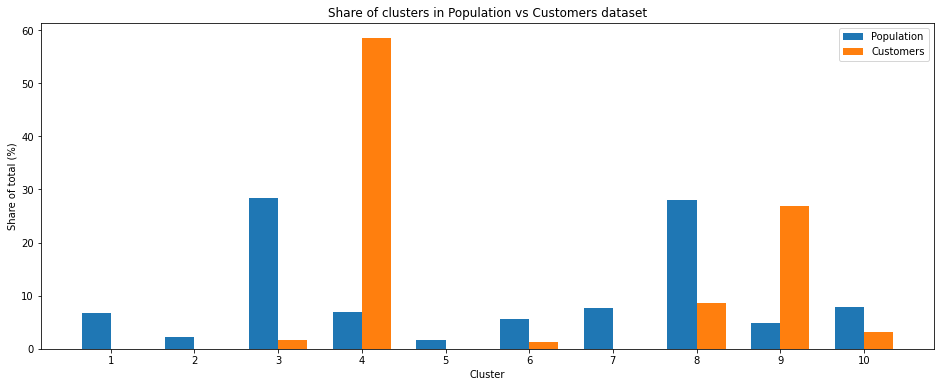

In [106]:
# Plot clusters 
fig, ax = plt.subplots(figsize=(16,6))

ind = np.arange(10)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, clusters['population_share'], width, bottom=0)
p2 = ax.bar(ind + width, clusters['customers_share'], width, bottom=0)

ax.set_title('Share of clusters in Population vs Customers dataset')
ax.set_ylabel('Share of total (%)')
ax.set_xlabel('Cluster')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(clusters['cluster'])
ax.legend((p1[0], p2[0]), ('Population', 'Customers'))
ax.autoscale_view()

plt.savefig('clusters_1.png', dpi=500);

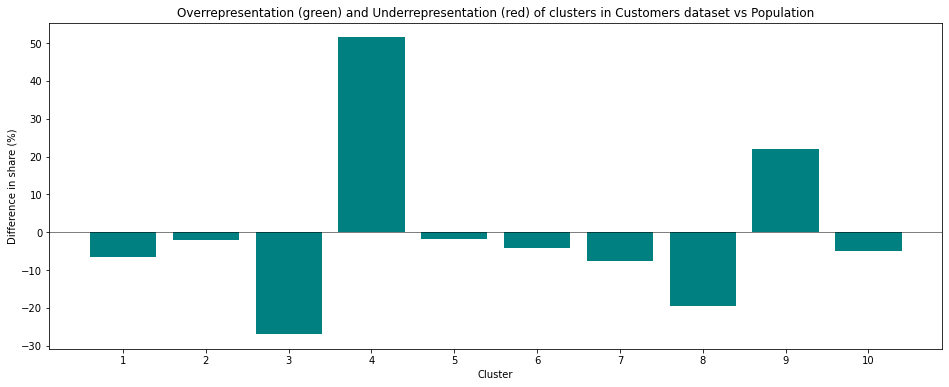

In [107]:
# Plot cluster differences
fig, ax = plt.subplots(figsize=(16,6))

ind = np.arange(10)    # the x locations for the groups
width = 0.35         # the width of the bars


p1 = ax.bar(ind, clusters['diff_share'], color="teal")

ax.set_title('Overrepresentation (green) and Underrepresentation (red) of clusters in Customers dataset vs Population')
ax.set_ylabel('Difference in share (%)')
ax.set_xlabel('Cluster')

ax.axhline(linewidth=.5, color='black')

ax.set_xticks(ind)
ax.set_xticklabels(clusters['cluster'])

plt.savefig('clusters_2.png', dpi=500);

# !

In [108]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca_cust.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca_cust.components_, columns = col_names_cu)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1)
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    

In [191]:
# Show highest positive and negative weights for 5 cluster (over representation of Customer)
pca_weights(4,4)

Principal Component:  4


Highest Positive weights:
ANZ_HAUSHALTE_AKTIV           0.256
ANZ_STATISTISCHE_HAUSHALTE    0.244
LP_LEBENSPHASE_FEIN           0.152
LP_FAMILIE_FEIN               0.075
Name: 3, dtype: float64


### So who does the cluster (4) with the largest swing toward the customer group represent?

1. ANZ_HAUSHALTE_AKTIV - number of households in the building
2. ANZ_STATISTISCHE_HAUSHALTE -  We dont have the explainer for this item
3. LP_LEBENSPHASE_FEIN - lifestage fine
4. LP_FAMILIE_FEIN - family type fine

In [110]:
# Show highest positive and negative weights for 5 cluster (over representation of Customer)
pca_weights(9,4)

Principal Component:  9


Highest Positive weights:
BALLRAUM            0.185
INNENSTADT          0.171
LP_STATUS_FEIN      0.169
MIN_GEBAEUDEJAHR    0.140
Name: 8, dtype: float64


### So who does the cluster (9) with the 2nd largest swing toward the customer group represent?

1. BALLRAUM - distance to the next metropole
2. INNENSTADT -  distance to the city centre
3. LP_STATUS_FEIN - social status fine 
4. MIN_GEBAEUDEJAHR-> year the building was first mentioned in our database.. This certainly seems odd however it could be linked to CLV ( Customer Lifetime Value) and/ or reccomendation of services due to product being in localized area( penetration).

## Lets dive deeper still preforming reverse PCA on our customer data set specifically putting cluster 4 under focus:


In [119]:
clusters = data_red_cust['customer_cluster']
data_red_cust=data_red_cust.drop(columns=['customer_cluster'])
inversed = pca_cust.inverse_transform(data_red_cust)
customer_reverse_trans= pd.DataFrame(inversed)
customer_reverse_trans.columns = col_names_cu
# Re attach the clusters
customer_reverse_trans['clusters'] = clusters

In [129]:
print(np.sort(clusters.unique()))

[0 1 2 3 4 5 6 7 8 9]


In [142]:

customer_means_cluster= []
for c in (np.sort(clusters.unique())):
    print(c)
    customer_cluster = customer_reverse_trans[customer_reverse_trans['clusters'] == c] 
    clust_stats=pd.DataFrame(customer_cluster.describe().T)
    if c ==0:
        test_clust= pd.DataFrame(clust_stats['mean'])
    else:
        clust_data= pd.DataFrame(clust_stats['mean'])
        test_clust=pd.concat([test_clust,clust_data], axis=1)
test_clust.columns =np.sort(clusters.unique())

0
1
2
3
4
5
6
7
8
9


In [151]:
test_clust= test_clust.T
test_clust.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CUSTOMER_GROUP_SINGLE_BUYER,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,O,W,EINGEZOGENAM_HH_JAHR_FE,GEBURTSJAHR_binned,MIN_GEBAEUDEJAHR_FE,clusters
0,-0.075661,1.586891,7.853579,9.965730,5.406412,0.043107,0.078042,1.787180,4.926954,0.012974,...,0.324433,0.234301,0.508199,0.257500,0.042406,0.642118,24.130569,81.436358,29.244271,0.0
1,0.407640,1.696302,8.483770,10.009558,3.434677,0.031243,0.083674,2.014611,3.167167,0.015596,...,0.435691,0.228278,0.408629,0.363093,0.410699,0.389535,23.925898,80.877686,28.983817,1.0
2,0.367019,1.589672,8.439579,10.071583,3.334518,0.029403,0.145441,2.045783,3.184529,0.010511,...,0.305865,0.203199,0.532352,0.264449,0.055009,0.712250,24.031284,80.883514,29.264968,2.0
3,0.399041,1.569237,8.680178,9.759706,2.581379,0.022488,0.093288,1.996088,2.436565,0.011451,...,0.315564,0.222521,0.514589,0.262890,0.049625,0.744773,23.927998,81.395305,29.181414,3.0
4,0.389644,1.595419,8.431475,9.912178,3.943538,0.035186,0.094581,1.976360,3.611784,0.009657,...,0.303038,0.230103,0.531847,0.238050,0.063233,0.749616,24.104535,80.936044,29.278806,4.0


### cluster4_factors= test_clust[['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','LP_LEBENSPHASE_FEIN','LP_FAMILIE_FEIN']]        #.iloc[5]
print(cluster4_factors.head(10))
cluster4__HPW= pd.DataFrame(cluster4_factors.iloc[3]) #HPW-higest positive weights
cluster4__HPW.columns=['cluster4']
cluster4__HPW

In [261]:
def factor_v_pop_log(factor,ind):
    factor_val=cluster4__HPW['cluster4'].loc[cluster4__HPW.index[ind]]
    print("Mean analysis for:",factor, factor_val)
    sns.kdeplot(data=np.log(azdias_short_df[factor]),color='red')
    sns.kdeplot(data=np.log(customers_cleaned[factor]),color='blue')

    plt.axvline(np.log(factor_val), 0,5000)
    plt.show()
    

In [284]:
def factor_v_pop(factor,ind):
    factor_val=cluster4__HPW['cluster4'].loc[cluster4__HPW.index[ind]]
    print("Mean analysis for:",factor, factor_val)
    sns.kdeplot(data=azdias_short_df[factor],color='red')
    sns.kdeplot(data=customers_cleaned[factor],color='blue')
    sns.distplot(customers_cleaned[factor],color='orange')


    plt.axvline(factor_val, 0,5000)
    plt.show()

Mean analysis for: ANZ_HAUSHALTE_AKTIV 2.5813789612671014


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


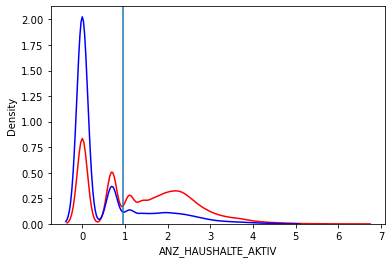

In [262]:
factor_v_pop_log('ANZ_HAUSHALTE_AKTIV',0)

**1. ANZ_HAUSHALTE_AKTIV	number of households in the building	…	numeric value (typically coded from 1-10)**

Mean analysis for: ANZ_STATISTISCHE_HAUSHALTE 2.436565101208824


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


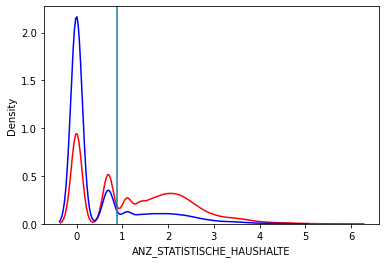

In [264]:
factor_v_pop_log('ANZ_STATISTISCHE_HAUSHALTE',1)

**2. ANZ_STATISTISCHE_HAUSHALTE -  We dont have the explainer for this item** However it looks suspiciously similar to the previous item

Mean analysis for: LP_LEBENSPHASE_FEIN 17.35405701753133


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


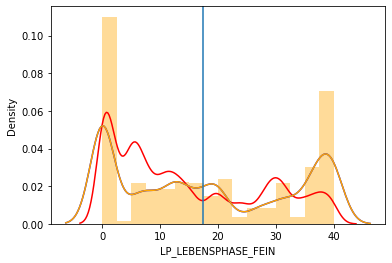

In [285]:
factor_v_pop('LP_LEBENSPHASE_FEIN',2)

Peaks at ~0,21, 39 which translate to:

1. low earners- unlikely this is likely an artifact of a data fill with 0. So lets remove this from our analysis.
2. single parents - low-average income....
3. top earners of middle age from mulitperson households

Mean analysis for: LP_FAMILIE_FEIN 3.7603087878385546


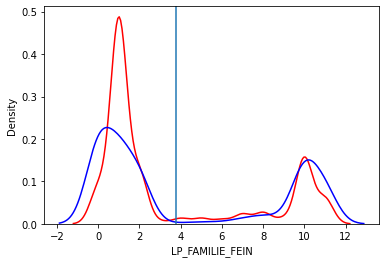

In [272]:

factor_v_pop('LP_FAMILIE_FEIN',3)


## Legend map for LP_FAMILIE_FEIN
Note either there is an error in the datasets of the legend, assume there is an offset in legand -1.
Value for cluster4 3.86 is indicated here for this value.


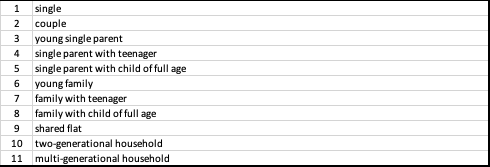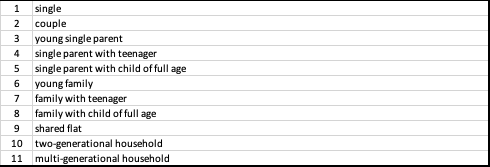

In [246]:
cluster9_factors= test_clust[['BALLRAUM',
'INNENSTADT',
'LP_STATUS_FEIN',
'MIN_GEBAEUDEJAHR']]        #.iloc[5]
print(cluster9_factors.head(10))
cluster9__HPW= pd.DataFrame(cluster9_factors.iloc[8]) #HPW-higest positive weights
cluster9__HPW.columns=['cluster9']
cluster9__HPW

   BALLRAUM  INNENSTADT  LP_STATUS_FEIN  MIN_GEBAEUDEJAHR
0  4.946797    4.825778        6.823567       1992.755729
1  4.517075    4.844744        6.534676       1993.016183
2  4.688058    4.706375        6.813864       1992.735032
3  4.904098    4.807458        7.012207       1992.818586
4  4.186004    4.599484        5.903879       1992.721194
5  5.527459    4.567139        6.771053       1992.823051
6  4.718675    4.855532        6.844095       1992.772522
7  6.468143    4.618987        6.982097       1992.233340
8  4.577764    4.700100        8.727109       1992.834902
9  6.195805    4.575032        6.259468       1992.852367


,cluster9
BALLRAUM,4.577764
INNENSTADT,4.700100
LP_STATUS_FEIN,8.727109
MIN_GEBAEUDEJAHR,1992.834902


In [496]:
def factor_v_pop(factor,ind):
    factor_val=cluster9__HPW['cluster9'].loc[cluster9__HPW.index[ind]]
    print("Mean analysis for:",factor, factor_val)
    sns.kdeplot(data=azdias_short_df[factor],color='red')
    sns.kdeplot(data=customers_cleaned[factor],color='blue')

    plt.axvline(factor_val, 0,5000)
    plt.show()

Mean analysis for: BALLRAUM 4.577763639404957


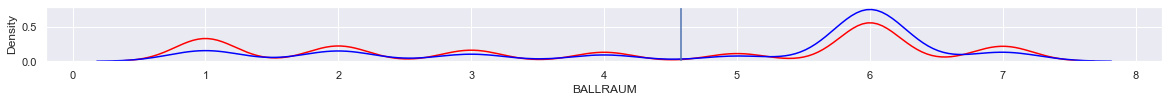

In [497]:
factor_v_pop('BALLRAUM',0)


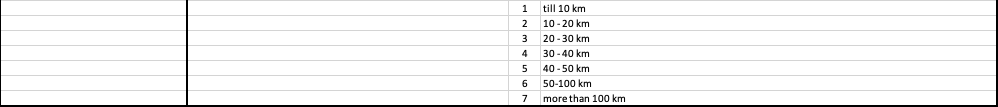

##### Clearly there is a signal here. Our customers live further away from urban centers with the largest peak at 50-60Km. Which might be the delivery range limitations perhaps.

Mean analysis for: INNENSTADT 4.7000998192338495


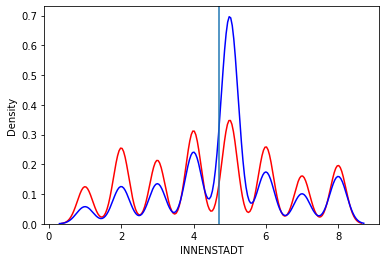

In [280]:
factor_v_pop('INNENSTADT',1)

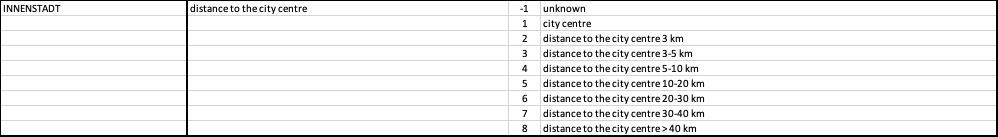

##### Again a signal here at #5 distance to city centre 10 - 20km, this seems in conflict with the previous factor.

Mean analysis for: LP_STATUS_FEIN 8.727108665407211


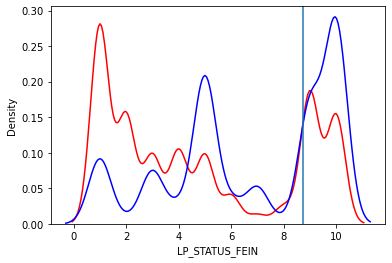

In [281]:
factor_v_pop('LP_STATUS_FEIN',2)

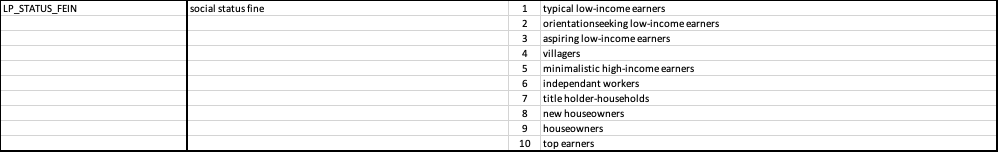

##### Perhaps the most telling factor we have seen so far, customers are either minimalistic high-income earners, new householders or top earners. The elite by any standard.

Mean analysis for: MIN_GEBAEUDEJAHR 1992.834901790223


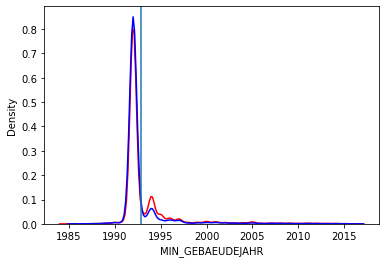

In [279]:
factor_v_pop('MIN_GEBAEUDEJAHR',3)

##### year the building was first mentioned in our database- why would this factor exist in the general population?

--------

### Now that we have looked at the data and completed some unsupervised learning techniques Who are our customers?

    Up to now we have presented a lot of 'data' to support the follow generalizations about the customer. Certainly there is not just a single customer type however the 'data' supports that the 

    **Predominant customer has the following attributes:**

    1. Was born in the **1950-60's** or even before.

    2. High or top income earners, is this making the assumption that the individuals are not retired we dont know. Perhaps the most telling factor we have seen so far, customers are either minimalistic high-income earners, new householders or top earners. The elite by any standard. However from multiple vectors these individuals are **high net** individuals.

    3. Location of domicile shows a very strong signal which seems contradictorary. There are two signals. The first indicates Clearly there is a signal here. Our customers live further away from urban centers with the largest peak at 50-60Km. Which might be the delivery range limitations perhaps. The seccond factor- distance to city centre 10 - 20km, this seems in conflict with the previous factor. Perhaps these can be reconciled with the individuals living far from a main urban city but closer to a smaller urban setting. These are **affulant sub-urban areas**.

    4. Larger proportion of customers are in 1,2,3 ie. over all **good neighbourhoods**. Much lesser representation in poor areas with some representation in rural areas.

    **the seccondary customer base is quite different:**

    If you play the Predominant customer base foward is it quite obivious that there would be issues around the age group. Thus it is important to attract a younger base. Initally when the younger single parent cluster surfaced in the data it was at odds with the over all trend however there are multiple surfacing of items related to this quite different customer cluster. Indeed this should be the cluster which is targeted to ensure growth of the buisness.


-----------

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [435]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [436]:
mailout_train_df = pd.read_pickle("./mailout_train_short-2.pkl")  


In [437]:
mailout_train_df

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
20218,41507,1,1.0,16.0,18.0,NaN,NaN,NaN,11.0,2.0,...,3.0,6.0,5.0,1.0,9.0,7.0,4,0,2,4
7886,43670,-1,1.0,21.0,NaN,NaN,NaN,NaN,16.0,1.0,...,1.0,1.0,1.0,2.0,9.0,7.0,1,0,1,3
7685,65330,1,1.0,12.0,NaN,NaN,NaN,NaN,12.0,6.0,...,1.0,2.0,1.0,6.0,9.0,5.0,3,0,2,3
7487,62107,-1,4.0,15.0,NaN,NaN,NaN,NaN,15.0,5.0,...,1.0,1.0,1.0,3.0,8.0,0.0,6,0,1,3
25213,4494,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,3.0,...,10.0,13.0,10.0,NaN,9.0,3.0,3,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32933,59706,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,NaN,...,7.0,10.0,10.0,0.0,9.0,NaN,3,0,2,4
38670,15476,2,1.0,16.0,NaN,NaN,NaN,NaN,11.0,NaN,...,4.0,4.0,2.0,2.0,9.0,NaN,3,0,2,3
6644,72759,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,2
29179,25843,-1,1.0,0.0,NaN,NaN,NaN,NaN,15.0,2.0,...,1.0,1.0,1.0,3.0,9.0,7.0,1,0,1,4


In [438]:
mailout_processed_df = transformer(mailout_train_df,9,30,0,0)

number of columns to drop: 6
number of nan's imputed with 'most-frequent' 1794302
 imputation insertion % 12.64445835366982
number of Skewed columns 32
% of inital dataset remaining: 93.9241553211032
 Transformation complete have a nice day !!! :)


In [439]:
mailout_processed_df
#mailout_processed_df = mailout_processed_df.sample(frac=0.3, replace=True, random_state=1)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,O,W,EINGEZOGENAM_HH_JAHR_FE,GEBURTSJAHR_binned,MIN_GEBAEUDEJAHR_FE
20218,1.0,1.0,16.0,11.0,2.0,0.0,1.0,3.0,2.0,0.0,...,2.645751,4.0,0.0,2.0,4.0,0.0,1.0,28.0,80.0,30.0
7886,-1.0,1.0,21.0,16.0,1.0,0.0,0.0,6.0,1.0,0.0,...,2.645751,1.0,0.0,1.0,3.0,0.0,1.0,23.0,90.0,25.0
7685,1.0,1.0,12.0,12.0,6.0,0.0,0.0,2.0,6.0,0.0,...,2.236068,3.0,0.0,2.0,3.0,0.0,1.0,15.0,70.0,28.0
7487,-1.0,4.0,15.0,15.0,5.0,0.0,0.0,1.0,5.0,0.0,...,0.000000,6.0,0.0,1.0,3.0,1.0,0.0,11.0,60.0,25.0
25213,2.0,1.0,9.0,9.0,3.0,0.0,0.0,0.0,3.0,0.0,...,1.732051,3.0,0.0,2.0,4.0,0.0,1.0,16.0,90.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32933,2.0,1.0,10.0,10.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.732051,3.0,0.0,2.0,4.0,0.0,0.0,23.0,80.0,30.0
38670,2.0,1.0,16.0,11.0,1.0,0.0,0.0,3.0,1.0,0.0,...,1.732051,3.0,0.0,2.0,3.0,0.0,0.0,25.0,80.0,30.0
6644,-1.0,1.0,0.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.732051,3.0,0.0,2.0,2.0,0.0,0.0,28.0,90.0,30.0
29179,-1.0,1.0,0.0,15.0,2.0,0.0,0.0,2.0,2.0,0.0,...,2.645751,1.0,0.0,1.0,4.0,0.0,1.0,25.0,60.0,30.0


In [475]:
print("the number of respondents was:",mailout_processed_df['RESPONSE'].sum())
print("the number of individuals mailed out was:", mailout_processed_df['RESPONSE'].count())

print("% of respondents:", (100/mailout_processed_df['RESPONSE'].count())*(mailout_processed_df['RESPONSE'].sum()))


the number of respondents was: 461.0
the number of individuals mailed out was: 37126
% of respondents: 1.241717394817648


In [503]:
X = mailout_processed_df.drop(['RESPONSE'], axis=1)
column_names= X.columns

y = mailout_processed_df['RESPONSE']


In [441]:
robust_Scaler = preprocessing.RobustScaler()
X = robust_Scaler.fit_transform(X)

In [442]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)


In [447]:
# create the pipeline
pipe = Pipeline(steps=[ ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}



search = GridSearchCV(pipe, param_grid,scoring = 'roc_auc', n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.713:
Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 20}


In [458]:
# create the pipeline
pipe = Pipeline(steps=[ ('GBC', GradientBoostingClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
     "GBC__n_estimators": [100,1000,1500],
    "GBC__max_depth": [1,3,5,8,9,],
    "GBC__learning_rate": [0.001,0.005,0.01, 0.025, 0.05],
    
    "GBC__max_features":['sqrt'],

}



search = GridSearchCV(pipe, param_grid,scoring = 'roc_auc', n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GBC_best_params = search.best_params_
GBC_best_model = search.best_estimator_

Best CV score = 0.755:
Best parameters:  {'GBC__learning_rate': 0.05, 'GBC__max_depth': 1, 'GBC__max_features': 'sqrt', 'GBC__n_estimators': 1500}


In [26]:
# create the pipeline
pipe = Pipeline(steps=[ ('mlpc', MLPClassifier())])

param_grid = {'mlpc__activation':['relu'],
              'mlpc__solver': ['adam'],
              'mlpc__max_iter': [1500,1600,1700],
              'mlpc__alpha': [0.0001,0.001],
              'mlpc__hidden_layer_sizes':np.arange(10, 30),
              'mlpc__random_state':[7]} # hmm thats a lot, scale it down to test run.

search = GridSearchCV(pipe, param_grid,scoring = 'roc_auc', n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
Mlpc_best_params = search.best_params_
Mlpc_best_model = search.best_estimator_

Best CV score = 0.631:
Best parameters:  {'mlpc__activation': 'relu', 'mlpc__alpha': 0.001, 'mlpc__hidden_layer_sizes': 19, 'mlpc__max_iter': 1500, 'mlpc__random_state': 7, 'mlpc__solver': 'adam'}


In [459]:
# create the pipeline
pipe = Pipeline(steps=[ ('GBC', GradientBoostingClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
     "GBC__n_estimators": [1400],
    "GBC__max_depth": [6],
    "GBC__learning_rate": [0.001],
    
}


search = GridSearchCV(pipe, param_grid,scoring = 'roc_auc', n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GBC_optim_parmas = search.best_params_
GBC_optim_model = search.best_estimator_

Best CV score = 0.767:
Best parameters:  {'GBC__learning_rate': 0.001, 'GBC__max_depth': 6, 'GBC__n_estimators': 1400}


In [498]:
GBC_optim_model.named_steps['GBC']


GradientBoostingClassifier(learning_rate=0.001, max_depth=6, n_estimators=1400)

Text(0.5, 0, 'feature importance')

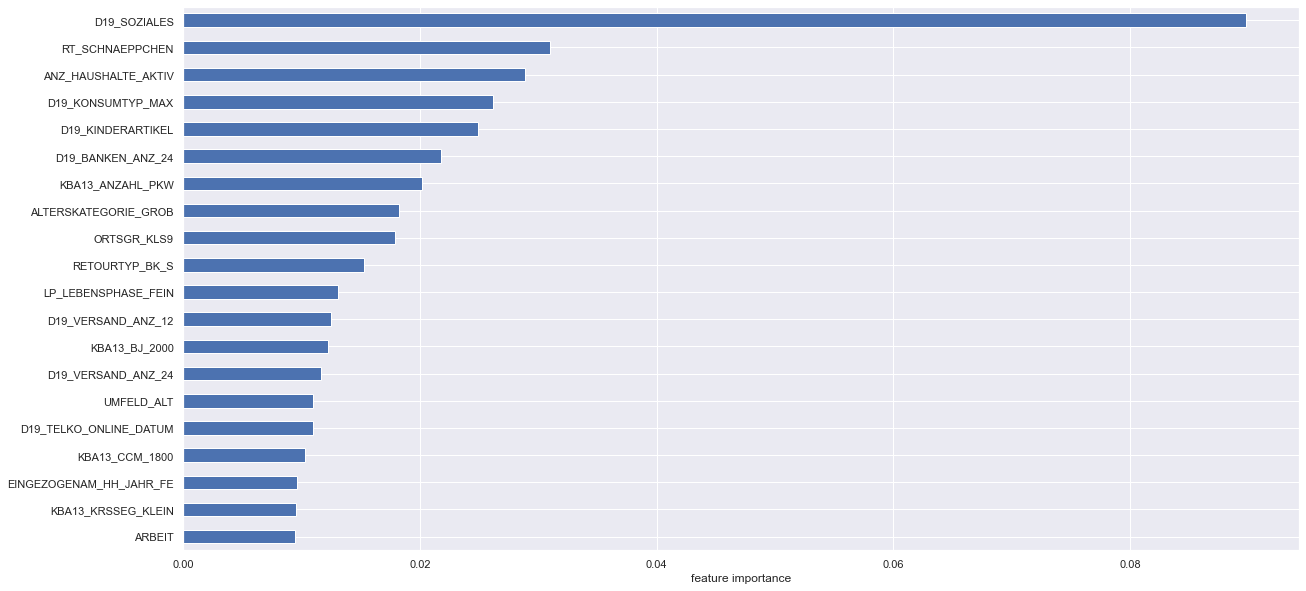

In [509]:
feature_importances = GBC_optim_model.named_steps['GBC'].feature_importances_
pd.Series(feature_importances, index=[''] + column_names).sort_values()[-20:].plot(kind='barh', figsize=(20,10))
plt.xlabel('feature importance')


D19_SOZIALES flagged as the factor with the largest weight in our binary predictive model. We don,t have an detailed explanation for this factor. We do know as it is a D19 it describes household behaviour and perhaps Social. Looking at this feature for the customer group versus the general population show an interesting difference between the two. This was not picked up previously and shows the power of tree based models to aid with explainability of factors and also show that this technique is valid as a data mining method also.
 


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


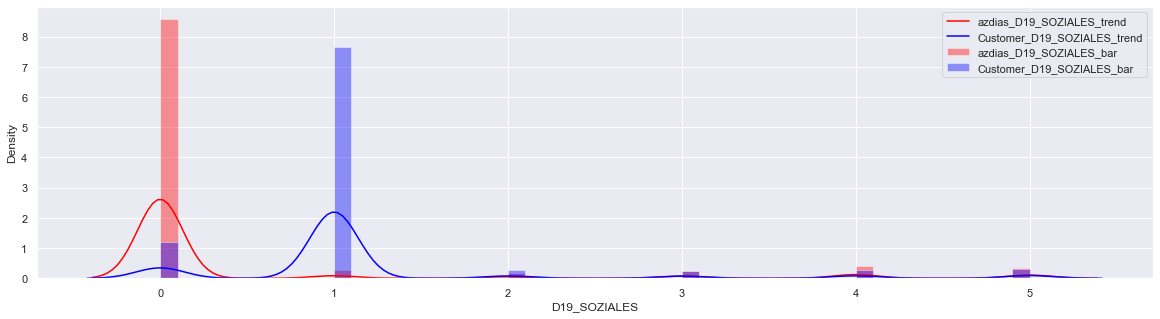

In [510]:
fig, ax = plt.subplots(figsize=(20, 5))


sns.distplot(azdias_processed['D19_SOZIALES'],color='red')
sns.distplot(customers_cleaned['D19_SOZIALES'],color='blue')
plt.legend(labels=['azdias_D19_SOZIALES_trend', 'Customer_D19_SOZIALES_trend', 'azdias_D19_SOZIALES_bar','Customer_D19_SOZIALES_bar'])

plt.show()

None the less there is a large differnetial between the customer group and the general population for this factor.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try violinplot
  warnings.warn(msg, UserWarning)


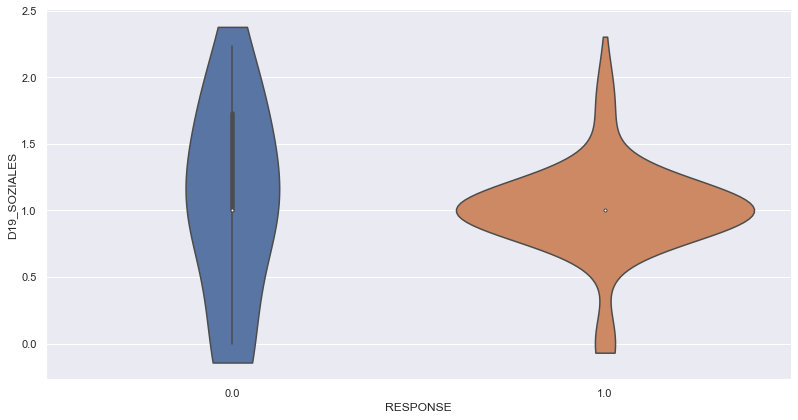

In [513]:
sns.catplot(ax=ax,
    data=mailout_processed_df, x="RESPONSE", y="D19_SOZIALES",kind="violin", bw=.7, cut=0.3, split=True,
height=6, aspect=15/8)